# Pan01 surface fluxes

Variables:
- `pme_river` = mass flux of precip-evap+river via sbc (liquid, frozen, evaporation)
   - the equivalent of `wfo` from MOM6 
- `pme_net` = precip-evap into ocean (total w/ restore + normalize)
- `river` = mass flux of river (runoff + calving) entering ocean
- `runoff` = mass flux of liquid river runoff entering ocean
- `evap` = mass flux from evaporation/condensation (>0 enters ocean)
- `melt` = water flux transferred with sea ice form/melt (>0 enters ocean)
- `fprec` = snow falling onto ocean (>0 enters ocean)
- `lprec` = liquid precip (including ice melt/form) into ocean (>0 enters ocean)
- `wfimelt` = water into ocean due to ice melt (>0 enters ocean)
- `wfiform` = water out of ocean due to ice form (>0 enters ocean)
- `sfc_salt_flux_restore` = flux from restoring term
- `sfc_salt_flux_ice` = downward_sea_ice_basal_salt_flux
- `sfc_salt_flux_coupler` = flux from the coupler

In [5]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [6]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33193/status,
Dashboard: /proxy/33193/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43773,Workers: 0
Dashboard: /proxy/33193/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39971,Total threads: 1
Dashboard: /proxy/33591/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:39595,


In [7]:
#Importing data
pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean_month.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean_month.nc'))

In [20]:
lat_slice = slice(None,-59)
time_slice = slice('1910-01-01','1919-12-31')

In [21]:
# Time variant variables
def preprocess_1(ds):
    ds = ds[['pme_river','sfc_salt_flux_ice','sfc_salt_flux_restore']].sel(yt_ocean=lat_slice) 
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess_1, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess_1, chunks = 'auto')

In [22]:
cont = cont.sel(time= time_slice)
melt = melt.sel(time = time_slice)

In [23]:
# Area
area = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']
var = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean.nc')['salt'].isel(st_ocean=0,time=0)

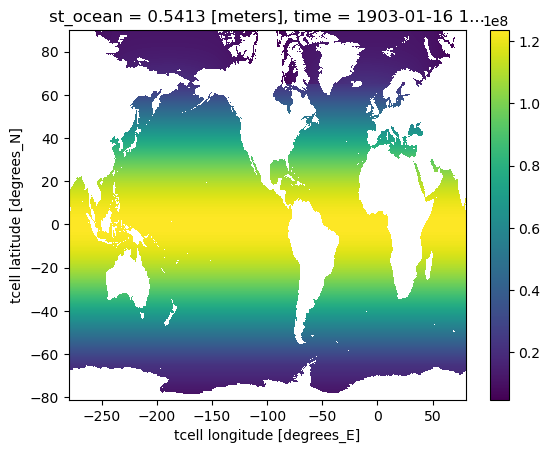

In [24]:
area_corr = area*(var*0 +1)
area_corr.plot()

In [25]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [26]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

 Let's look at water mass flux first.

In [27]:
water_C = cont['pme_river']
water_M = melt['pme_river']

Time series over shelf

In [28]:
water_shelf_C = water_C.where(shelf_mask ==1)
water_shelf_M = water_M.where(shelf_mask ==1)

In [29]:
# Spatial average
water_time_C = (area_corr * water_shelf_C).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])
water_time_M = (area_corr * water_shelf_M).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])

In [30]:
water_time_C

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00

In [31]:
water_time_C = water_time_C.load()
water_time_M = water_time_M.load()

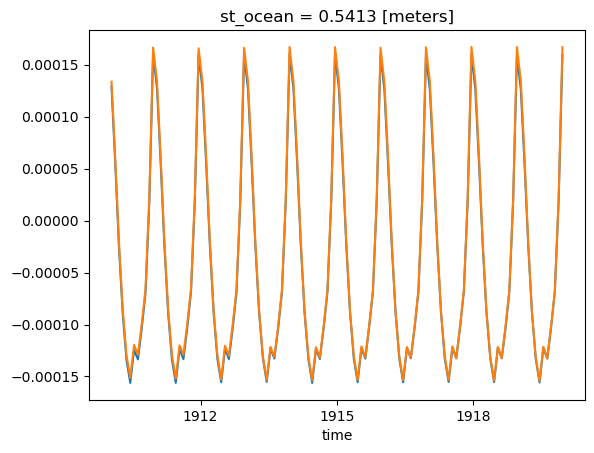

In [32]:
water_time_C.plot()
water_time_M.plot()

In [33]:
water_shelf_anom = water_time_M - water_time_C
water_shelf_anom = water_shelf_anom.load()

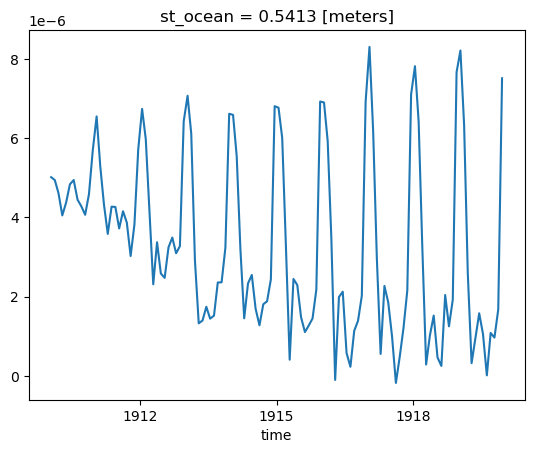

In [34]:
water_shelf_anom.plot()

In [35]:
water_shelf_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/wfo_shelf_time_prescribed_ACCESS.nc')

# Salinity Surface flux

In [36]:
salt_C = cont['sfc_salt_flux_ice'] + cont['sfc_salt_flux_restore']
salt_M = melt['sfc_salt_flux_ice'] + melt['sfc_salt_flux_restore']

In [37]:
salt_shelf_C = salt_C.where(shelf_mask ==1)
salt_shelf_M = salt_M.where(shelf_mask ==1)

In [38]:
# Spatial average
salt_time_C = (area_corr * salt_shelf_C).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])
salt_time_M = (area_corr * salt_shelf_M).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])

In [39]:
salt_time_C

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 960B 1910-01-16 12:00:00 ... 1919-12-16 12:00:00

In [40]:
salt_time_C = salt_time_C.load()
salt_time_M = salt_time_M.load()

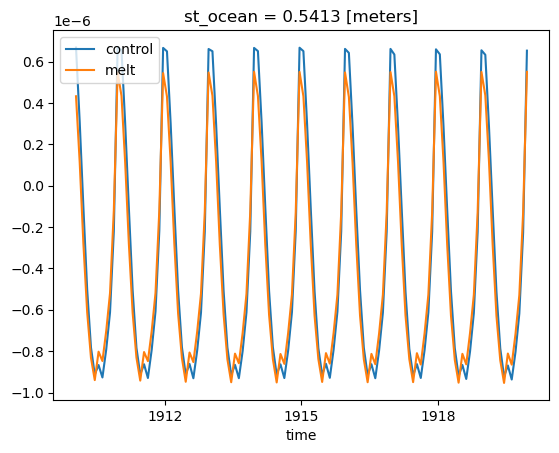

In [43]:
salt_time_C.plot(label='control')
salt_time_M.plot(label = 'melt')
plt.legend()

In [44]:
salt_shelf_anom = salt_time_M - salt_time_C
salt_shelf_anom = salt_shelf_anom.load()

In [45]:
salt_shelf_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/saltflux_shelf_time_prescribed_ACCESS.nc')